In [1]:
import pathlib

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import numpyro.infer as infer

jax.config.update("jax_enable_x64", True)

### Load grids and model spectra

In [2]:
data_path = pathlib.Path("../data/")
grid_path = data_path / "grid_params"

grids = np.load(data_path / "teff_logg_mh_grids.npz")
grids = (grids["arr_0"], grids["arr_1"], grids["arr_2"])
grids_shape = tuple(dim for g in grids for dim in g.shape)

In [3]:
spec_files = sorted(grid_path.glob("*.csv"))
flux = None
for i, filename in enumerate(spec_files):
    spec = np.loadtxt(filename, delimiter=",", skiprows=1)
    if flux is None:
        flux = np.zeros((len(spec_files), spec.shape[0]))
    flux[i] = spec[:, 1]

flux = jnp.array(flux.reshape((*grids_shape, -1)))

pix = jnp.arange(flux.shape[-1])

In [4]:
interp = jax.scipy.interpolate.RegularGridInterpolator(
    grids, flux[..., i], method="linear", bounds_error=False, fill_value=None
)
interp(np.array([[4833, 2.23, 0.05]]))

Array([0.98224027], dtype=float64)

In [5]:
def interp_pix(i, teff, logg, mh):
    interp = jax.scipy.interpolate.RegularGridInterpolator(
        grids, flux[..., i], method="linear", bounds_error=False, fill_value=None
    )
    return interp(jnp.array([[teff, logg, mh]]))[0]


interp_pix_vmap = jax.vmap(interp_pix, in_axes=(0, None, None, None))

In [6]:
# interp_flux = interp_pix_vmap(pix, 4833, 2.23, 0.05)
# plt.figure(figsize=(12, 4))
# plt.plot(interp_flux, marker="")

### Load test data spectrum to fit:

<ErrorbarContainer object of 3 artists>

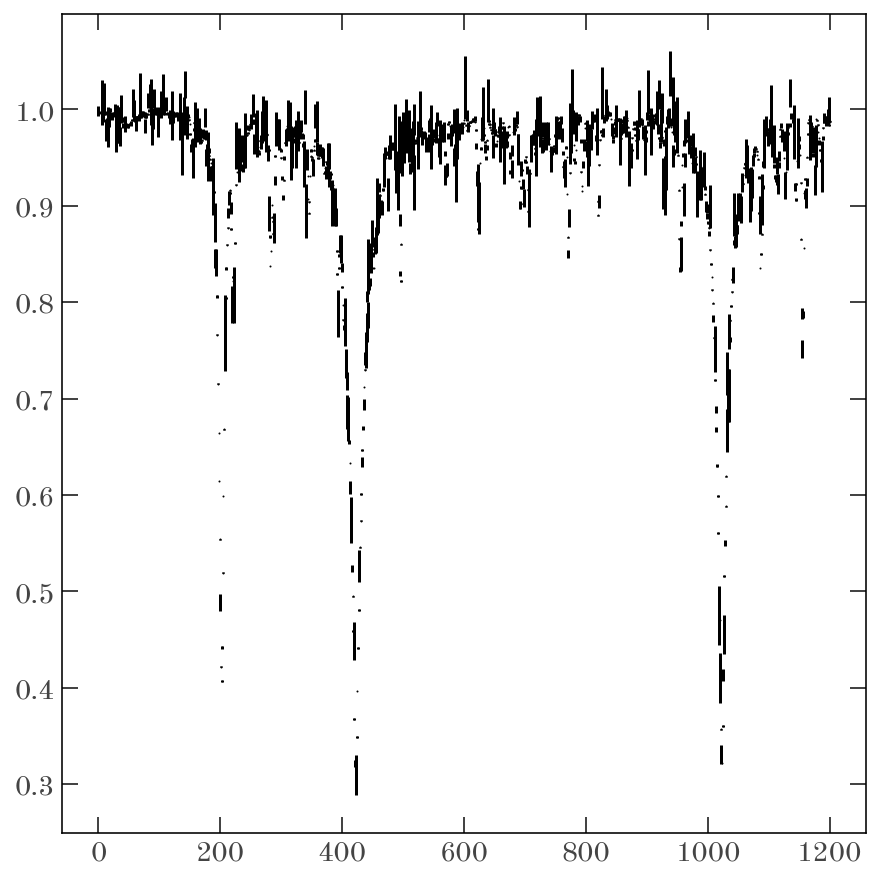

In [98]:
test_spec = np.loadtxt(
    data_path / "test_params/spectrum_00001.csv", delimiter=",", skiprows=1
)[:, 1]
true_params = np.load(data_path / "true_params.npy")[0]

# test_spec = np.loadtxt(
#     data_path / "test_params/spectrum_00002.csv", delimiter=",", skiprows=1
# )[:, 1]
# true_params = np.load(data_path / "true_params.npy")[1]

rng = np.random.default_rng(123)
flux_err = 10 ** rng.uniform(-4, -1.5, size=test_spec.shape)
# flux_err = 10 ** rng.uniform(-5, -4, size=test_spec.shape)

data = {"flux": rng.normal(test_spec, scale=flux_err), "flux_err": flux_err}
plt.errorbar(pix, data["flux"], yerr=data["flux_err"], fmt="o", markersize=1)

In [99]:
true_params

array([5.22739560e+03, 2.58777569e+00, 8.58597920e-02])

### Set up the numpyro model

In [100]:
teff_lim = (grids[0].min(), grids[0].max())
logg_lim = (grids[1].min(), grids[1].max())
mh_lim = (grids[2].min(), grids[2].max())

In [101]:
def grid_interp_model(flux, flux_err):
    teff = numpyro.sample("teff", dist.Uniform(*teff_lim))
    logg = numpyro.sample("logg", dist.Uniform(*logg_lim))
    mh = numpyro.sample("mh", dist.Uniform(*mh_lim))

    model_flux = interp_pix_vmap(pix, teff, logg, mh)
    numpyro.sample("obs", dist.Normal(model_flux, flux_err), obs=flux)

In [102]:
mcmc = infer.MCMC(
    infer.NUTS(grid_interp_model),
    num_warmup=1000,
    num_samples=4000,
    num_chains=4,
    thinning=4,
)
_ = mcmc.run(jax.random.PRNGKey(0), data["flux"], data["flux_err"])

/var/folders/67/2zgxpmyd2z183j4k6r33nf740000gr/T/ipykernel_73410/2977975018.py:1: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = infer.MCMC(
sample: 100%|██████████| 5000/5000 [00:02<00:00, 2256.11it/s, 7 steps of size 2.10e-01. acc. prob=0.93] 


In [103]:
idata = az.from_numpyro(mcmc)
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logg,2.587,0.001,2.586,2.588,0.000,0.00,3279.0,3738.0,1.0
mh,0.084,0.001,0.083,0.086,0.000,0.00,3037.0,3251.0,1.0
teff,5228.039,0.789,5226.595,5229.535,0.015,0.01,2948.0,3305.0,1.0


In [104]:
ref_vals = {"teff": true_params[0], "logg": true_params[1], "mh": true_params[2]}

array([[<Axes: ylabel='logg'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='mh'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='logg', ylabel='teff'>, <Axes: xlabel='mh'>,
        <Axes: xlabel='teff'>]], dtype=object)

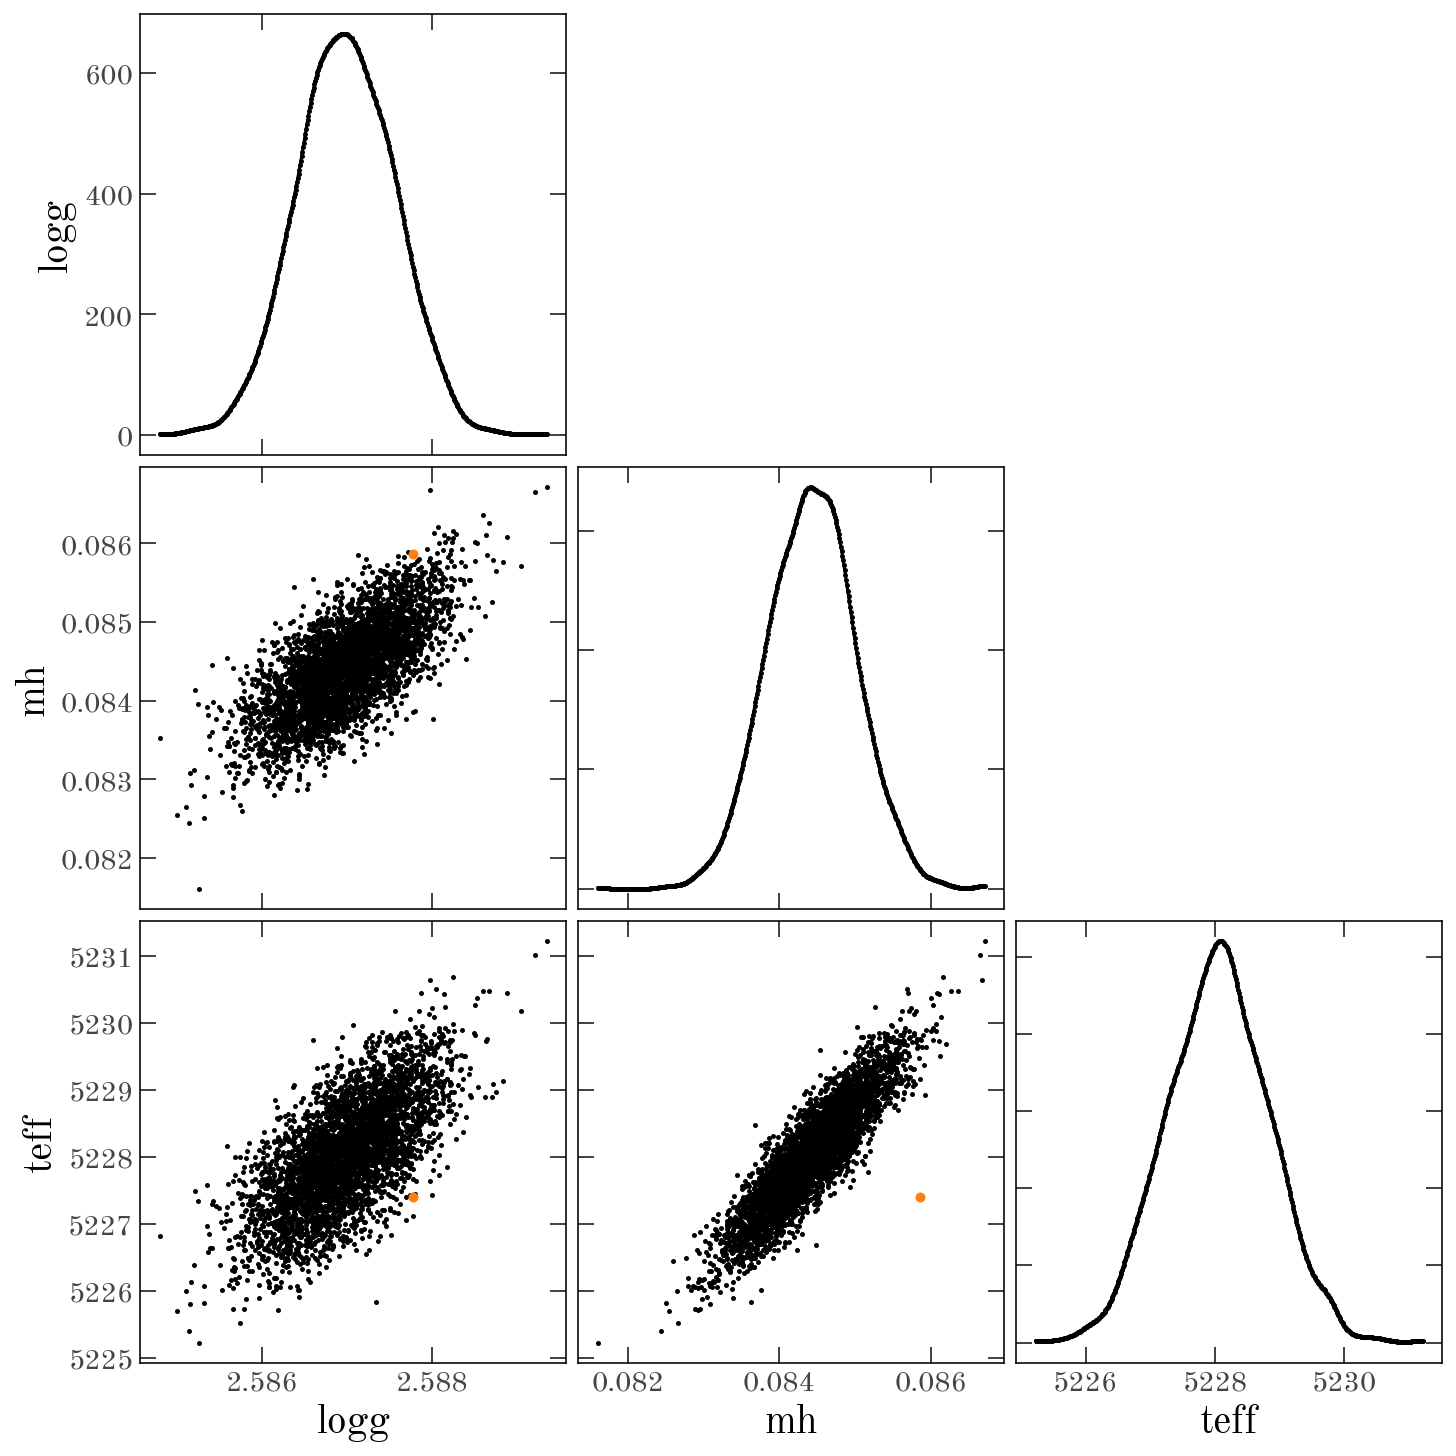

In [117]:
az.plot_pair(idata, marginals=True, reference_values=ref_vals, figsize=(10, 10))

---

## Alternate method: Evaluate on the grid and interpolate log-likelihood?

Notes: after experimenting with this, linear interpolation clearly isn't good enough here. So would need to use a higher-order interpolation method, or some other method of constructing a continuous density function from the evaluated grid.

In [106]:
grids_broadcast = np.meshgrid(*grids, indexing="ij")
grids_broadcast = [g.flatten() for g in grids_broadcast]

In [107]:
def loglike_interp_model(teff, logg, mh, flux, flux_err):
    model_flux = interp_pix_vmap(pix, teff, logg, mh)
    return jax.scipy.stats.norm.logpdf(flux, loc=model_flux, scale=flux_err).sum()


loglike_interp_model_vmap = jax.vmap(
    loglike_interp_model, in_axes=(0, 0, 0, None, None)
)

In [108]:
loglike_grid = loglike_interp_model_vmap(
    *grids_broadcast, data["flux"], data["flux_err"]
)

In [110]:
# assert np.all(
#     np.array([g[loglike_grid.argmax()] for g in grids_broadcast]) == true_params
# )

TODO: interpolate log-likelihood instead.

In [111]:
loglike_grid = loglike_grid.reshape(grids_shape)
interp_loglike = jax.scipy.interpolate.RegularGridInterpolator(
    grids, loglike_grid, method="linear", bounds_error=False, fill_value=None
)

In [113]:
def interp_loglike_model():
    teff = numpyro.sample("teff", dist.Uniform(*teff_lim))
    logg = numpyro.sample("logg", dist.Uniform(*logg_lim))
    mh = numpyro.sample("mh", dist.Uniform(*mh_lim))
    numpyro.factor("loglike", interp_loglike(jnp.array([[teff, logg, mh]]))[0])

In [114]:
mcmc_loglike = infer.MCMC(
    infer.NUTS(interp_loglike_model),
    num_warmup=1000,
    num_samples=4000,
    num_chains=4,
    thinning=4,
)
_ = mcmc_loglike.run(jax.random.PRNGKey(0))

/var/folders/67/2zgxpmyd2z183j4k6r33nf740000gr/T/ipykernel_73410/1970681369.py:1: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_loglike = infer.MCMC(
sample: 100%|██████████| 5000/5000 [00:01<00:00, 2553.19it/s, 159 steps of size 2.85e-05. acc. prob=0.86] 


In [115]:
idata_loglike = az.from_numpyro(mcmc_loglike)
az.summary(idata_loglike)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logg,2.533,0.086,2.400,2.600,0.042,0.018,5.0,30.0,2.36
mh,0.000,0.071,-0.100,0.100,0.035,0.018,5.0,23.0,2.46
teff,5101.467,84.156,4960.162,5221.572,41.634,21.753,5.0,11.0,2.94


array([[<Axes: ylabel='logg'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='mh'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='logg', ylabel='teff'>, <Axes: xlabel='mh'>,
        <Axes: xlabel='teff'>]], dtype=object)

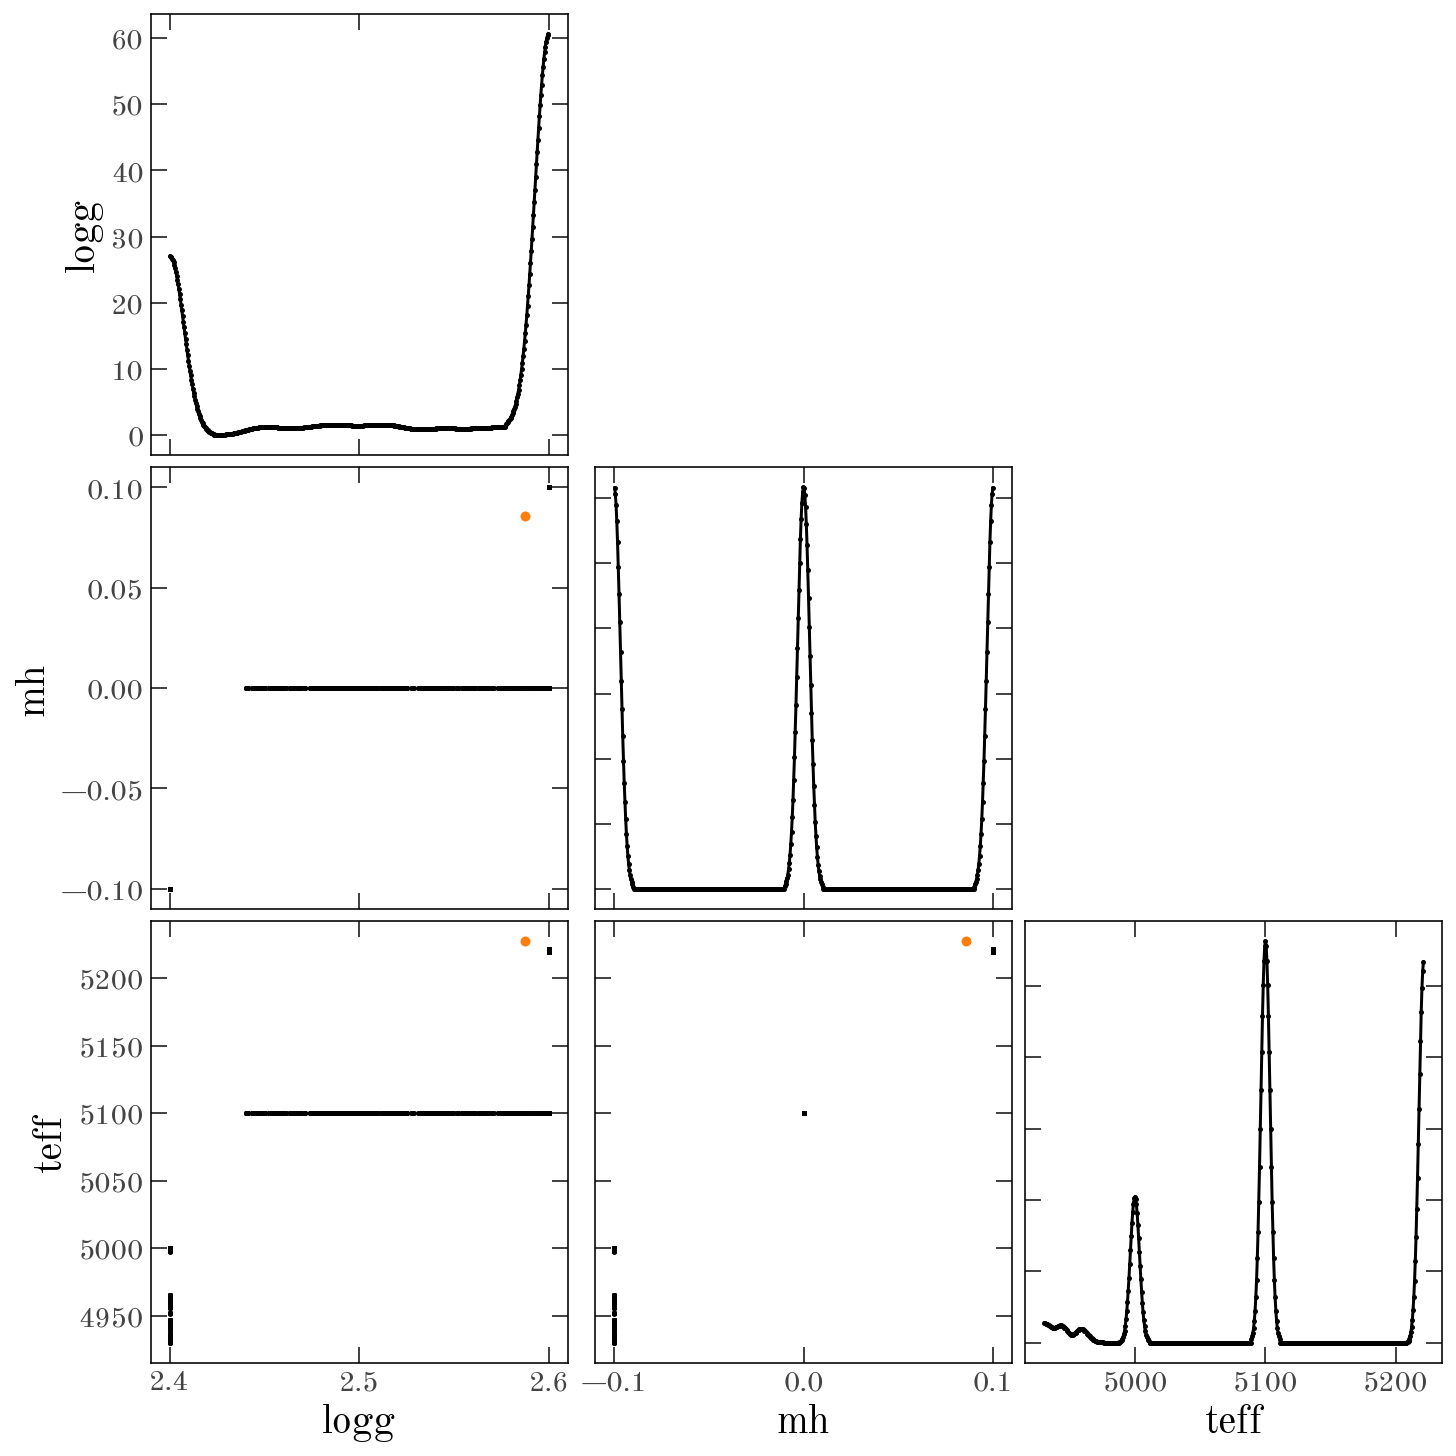

In [118]:
az.plot_pair(idata_loglike, marginals=True, reference_values=ref_vals, figsize=(10, 10))